# 1.1 Symbol Recognition with a CNN - Preprocessing.ipynb

### Dataset description 

The CROHME 2016 dataset contains ~80k training images, ~70k test images & 12.5k validation images. 
The images are stored as INKml files, which containthe strokes of the symbol along with the ground truth label. To prepare this dataset for processing, the following steps need to be taken:

 1. InkML files were parsed and converted to .png files on disk.
		1. Small tweaks were made to the InkML implementation to make the code more readable and fix some small bugs.
		2. Spot checks were done after the data was generated to check for obviously corrupt data files.
 2. The groundtruth label was extracted from the InkML file and a mapping between the gt label and filename was generated.
 3. Each png image was processed by tightly cropping the image, followed by a pad and a resize. Each image in the dataset is now 32x32 pixels. 
		1. Tensorflow scaling seemed to result in poor quality scaling, with shapes distorted beyond recognizability.l
		2. Hence, a cropping & scaling pipeline was developed:
			1. First, the image was cropped. Since the source data is effectively black and white, this was done by removing all the fully white rows & columns around the outside of the image.
			2. Second, we applied an erode filter. Since the image is black-on-white, this has the effect of thickening the strokes of the symbols.
			3. Third, we scaled the image. Empirically, a 64x64 size seemed a good compromise between size and quality. The scaling operation takes into account the aspect ratio, by resizing the longest side of the image first and adjusting the other side to keep the same aspect ratio. This prevents distorting the shapes.
 4. At this point, we have our training data (64x64 monochrome png images) and our ground truth labels.
		1. The number of unique symbols in this dataset is:
 5. Repeat the above steps for test & validation data
 
### Dataset 
 
[CROHME 2016 Dataset download link](http://tc11.cvc.uab.es/datasets/ICFHR-CROHME-2016_1)
 
The data can be found (when the archive is extracted) at: `CROHME2016_data/Task-2-Symbols/`. The files in there were extracted and manually split into the `train`, `test` and `validation` sets.

## Convert InkML files to PNG

InkML is a data format that is "stroke" based. In other words, the format describes shapes by a series of coordinates that define lines. Plotting each of the lines and saving the figure results in the final input image.

With credit to: https://github.com/ThomasLech/CROHME_extractor, whose code was adapted for this project.

Below we convert the images from InkML to PNG.

In [45]:
# Custom src import
import sys 
sys.path.append('../src/')
from inkml import inkml

The following project structure is used:
```
project/
    data/ -- Contains the data used in the project (both original and derived)
    doc/ -- Project documentation (including report & summary)
    figs/ -- Any saved figures generated by the project
    notebooks/ -- All notebooks for the project
    scripts/ -- Scripts used for various reasons, such as pre-processing
    src/ -- Regular python code
```

In [46]:
import os 

### Make sure our data is in order
data_base_dir = "../data"
figs_base_dir = "../figs"

original_data_path = data_base_dir + "/original/symbol/"
processed_data_path = data_base_dir + "/processed/symbol/"
pickle_data_path = data_base_dir + "/pickle/symbol/"

assert os.path.exists(original_data_path), "Original data path does not exist."
assert os.path.isdir(processed_data_path), "Original data path exists, but is not a directory."

if not os.path.exists(processed_data_path):
    print("Creating processed data path...")
    os.mkdir(processed_data_path)    

In [52]:
def parse_gt_label_key(data_dir):  
    ''' 
    Produce a mapping from the filename to the groundtruth label key
    '''
    p = Path(data_dir)
    paths = list(p.glob("**/*.inkml"))
    
    print(f"Parsing groundtruth label keys for {len(paths)} files.")
    
    count = 0 
    labels = []
    for path in paths:
        try:
            # Remove quotes as they mess up indexing
            key = str(inkml.get_groundtruth_label(path.absolute())                        )
            key =  key.replace('\"','')            
            labels.append((os.path.basename(path), key))
            count += 1
        except Exception as e:
            print(f"Encountered exception while processing.")
            print(f"Src: {path}")
            print(f"Exception: {e}")
            continue 
    return labels

def parse_gt_labels(data_dir):
    '''
    Produce a mapping from the label key to the groundtruth label
    '''
    p = Path(data_dir)
    paths = list(p.glob("**/*GT.txt"))
    
    print(f"Parsing groundtruth labels for {len(paths)} files.")
    
    label_frames = []
    for path in paths:
        try:
            label_frames.append(pd.read_csv(path, header=None))
        except Exception as e:
            print(f"Encountered exception while processing.")
            print(f"Src: {path}")
            print(f"Exception: {e}")
            continue
    complete_frame = pd.concat(label_frames, sort=False)
    return complete_frame.apply(lambda str : str.replace('"',''))

def process_data(data_dir, output_dir, generate_count=None, output_type=".png"):  
    '''
    Process the .inkml files and convert to 'output_type' files.
    
    Arguments:
    data_dir -- the directory with the InkML files
    output_dir -- the directory for the generated files
    generate_count -- maximum number of files to generate
    output_type -- the extension of the image type the generate
    '''
    p = Path(data_dir)
    paths = [str(path.absolute()) for path in list(p.glob("**/*.inkml"))]        
    target_paths = [path.replace(data_dir, output_dir) for path in paths]
    target_paths = [path.replace(".inkml", output_type) for path in target_paths]

    # Make sure target dirs exist
    target_dirs = [os.path.dirname(path) for path in target_paths]
    target_dirs = set(target_dirs)
    
    for target_dir in target_dirs:
        if not os.path.exists(target_dir):
            print(f"Creating directory: {target_dir}.")
            Path(target_dir).mkdir(parents=True, exist_ok=True)
    
    if generate_count is None:
        print(f"Converting {len(paths)} inkml files to {output_type}...")
    else:
        print(f"Converting {generate_count} inkml files to {output_type}...")
        
    count = 0 
    for src, target in zip(paths, target_paths):
        try:
            if not os.path.exists(target):
                inkml.convert_inkml_to_image(src, target)

            count += 1        
            if count % 500 == 0:
                print(f"{count}/{len(paths)}")  
            if generate_count is not None and count >= generate_count:
                return count
        except Exception as e:
            print(f"Encountered exception while processing.")
            print(f"Src: {src}")
            print(f"Target: {target}")
            print(f"Exception: {e}")
            continue
    return count

For demonstration purposes, below we convert one InkML file into a png, and display it.

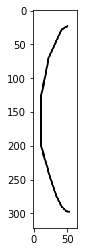

In [53]:
import matplotlib.pyplot as plt 

src = os.path.abspath(f"{original_data_path}/train/iso0.inkml")
target = os.path.abspath(f"{processed_data_path}/train/iso0.png")
inkml.convert_inkml_to_image(src, target)
plt.imshow(plt.imread(target))

In [54]:
from pathlib import Path

###################################
### Convert InkML files to pngs ###
###################################

process_dirs = [
    "train/",
    "test/",
    "validation/"
]
count = 50

for current_dir in process_dirs:    
    count = process_data(
        f"{original_data_path}{current_dir}",
        f"{processed_data_path}{current_dir}",
        generate_count=count
    )
    print(f"[{current_dir}] Converted {count} files.")

Converting 50 inkml files to .png...
[train/] Converted 50 files.
Converting 50 inkml files to .png...
[test/] Converted 50 files.
Converting 50 inkml files to .png...
[validation/] Converted 50 files.


## Parsing groundtruth labels

Below, we parse the ground truth symbol for the images. This is stored alongside the original data in a comma seperated values (csv) file.

In [55]:
import pandas as pd 

def parse_groundtruth_labels(groundtruth_path, processed_data_path):
    '''
    Parse groundtruth labels. This function produces a mapping from:
    filename -> path 
    filename -> groundtruth label
    '''
    # Get file -> key mapping
    filename_to_key_mapping = parse_gt_label_key(groundtruth_path)    
    filename_to_path_mapping = { entry[0] : f"{processed_data_path}{entry[0]}" for entry in filename_to_key_mapping}

    # and key -> label mapping
    key_to_label_df = parse_gt_labels(groundtruth_path)
    key_to_label_dict = key_to_label_df.set_index(0).T.to_dict('list')
    file_to_label_mappings = { file_mapping[0] : key_to_label_dict[file_mapping[1]][0] for file_mapping in filename_to_key_mapping}
    
    return filename_to_path_mapping, file_to_label_mappings

def filter_junk(filename_to_path, filename_to_label):  
    '''
    Filters out examples with a ground truth label of "junk"
    '''
    filtered_filename_to_path = {}
    filtered_filename_to_label = {}
    for f_to_p, f_to_l in zip(filename_to_path.items(), filename_to_label.items()):
        if f_to_l[1] == " junk":
            continue
        else:
            filtered_filename_to_path[f_to_p[0]] = f_to_p[1]
            filtered_filename_to_label[f_to_l[0]] = f_to_l[1]
    return filtered_filename_to_path, filtered_filename_to_label

In [56]:
################################################
### Parse ground truth labels for the images ###
#################################################

training_data_path = f"{original_data_path}/train/"
processed_train_data_path = f"{processed_data_path}/train/"

test_data_path = f"{original_data_path}/test/"
processed_test_data_path = f"{processed_data_path}/test/"

# Parse ground truth for training data 
train_filename_to_path, train_filename_to_label = parse_groundtruth_labels(training_data_path, processed_train_data_path)
unique_labels = list(set(train_filename_to_label.values()))
print(f"Found: {len(train_filename_to_label)} files with ground truth labels & {len(unique_labels)} unique labels. \n")

# Parse ground truth for test data 
test_filename_to_path, test_filename_to_label = parse_groundtruth_labels(test_data_path, processed_test_data_path)
test_filename_to_path, test_filename_to_label = filter_junk(test_filename_to_path, test_filename_to_label)
test_filename_to_label = dict(test_filename_to_label)
print(f"Found: {len(test_filename_to_label)} files with ground truth labels & {len(unique_labels)} unique labels.")

Parsing groundtruth label keys for 100 files.
Parsing groundtruth labels for 1 files.
Found: 100 files with ground truth labels & 13 unique labels. 

Parsing groundtruth label keys for 100 files.
Parsing groundtruth labels for 1 files.
Found: 56 files with ground truth labels & 13 unique labels.


At this point, we have:
- train_file_to_category -> a mapping between a filename in the training set and the label 
- test_file_to_category -> a mapping between a filename in the test set and the label 
- unique_labels -> an array of all the labels in the dataset

## Pre-process images

Below, we pad & crop images as appropriate to create a dataset where all images are a uniform size.

In [57]:
import time
from tensorflow.image import ResizeMethod
import cv2
import math
import numpy as np

def crop_image(image, min_size=(16,16)):
    ''' 
    Tightly crop image by removing whitespace at edges
    '''
    # Max values if pixels are all white (croppable space)
    max_sum_y = image.shape[0] * 255
    max_sum_x = image.shape[1] * 255
    
    # Compute a mask: 1 if we want to keep, 0 to discard
    imsum_x_equal_to_max = np.not_equal(np.sum(image,0), max_sum_y).astype(int)
    imsum_y_equal_to_max = np.not_equal(np.sum(image,1), max_sum_x).astype(int)
    
    # This will compute the index for non-zero entries
    # eg. [0,0,1,2,3,4,0,0]
    x_indices = np.multiply(imsum_x_equal_to_max.T,np.arange(image.shape[1]))
    y_indices = np.multiply(imsum_y_equal_to_max.T,np.arange(image.shape[0]))

    # Remove 0 elements
    x_indices = x_indices[np.nonzero(x_indices)]
    y_indices = y_indices[np.nonzero(y_indices)]
    if len(x_indices) == 0 or len(y_indices) == 0:
        return image
    elif len(x_indices) < len(y_indices) and len(x_indices) < min_size[0] or \
        len(y_indices) < len(x_indices) and len(y_indices) > min_size[1]:
        return image
    
    # Select rows, cols in range
    return image[np.min(y_indices):np.max(y_indices),np.min(x_indices):np.max(x_indices),:]
    
def pad_img(image, size, pad_with=255):
    # Make sure we're evenly divisible so we can pad equally on both sides
    add_rows = size[0] - image.shape[0]
    add_cols = size[1] - image.shape[1]
    assert add_rows >= 0, f"Attempt to crop (add_rows = {add_rows})"
    assert add_cols >= 0, f"Attempt to crop (add_cols = {add_cols})"
    start_row = int(math.floor(add_rows) / 2)
    start_col = int(math.floor(add_cols) / 2)
    
    # Perform padding
    m = np.ones(size) * pad_with
    m[
        start_row : image.shape[0] + start_row,
        start_col : image.shape[1] + start_col
    ] = image
    return m


def resize_img(image, size):
    ''' 
    Check if approximately square
    yes ~> resize to 32x32 
    no ~> resize longest side to 32, pad the rest
    '''
    assert size[0]==size[1], "Dimensions should be equal!"
    
    width = image.shape[0] 
    height = image.shape[1]
    aspect_ratio = width / height
    
    size_before_padding = (0,0)
    if math.fabs(1 - aspect_ratio) < 0.1:
        # Just scale down evenly
        size_before_padding = size
    elif aspect_ratio < 1.0:
        width = size[0]
        height = int(width * aspect_ratio)
        size_before_padding = (width, height)
    elif aspect_ratio > 1.0:
        height = size[1]
        width = int(height / aspect_ratio)
        size_before_padding = (width, height)

    try:
        resized_img = cv2.resize(image.numpy(), size_before_padding)
        return pad_img(resized_img, size)
    except Exception as e:
        count = 1

    return None

def safe_erode(image, kernel=np.ones((5,5), np.uint8)):
    try:
        im = cv2.erode(cropped_im.numpy(), dilate_kernel)
        return im
    except:
        return image

def display_img(image):
    color_img = tf.image.grayscale_to_rgb(image)
    plt.imshow(color_img)
    plt.show()
    
def is_all_white(image):
    np.sum(image)

In [58]:
import tensorflow as tf

def process_images(file_to_path, file_to_category, erode=True, size=(128,128)):
    '''
    file_to_path - Dictionary with the imagename as the key and the path as the value
    image_to_label - Dictionary with the imagename as the key, and the label as the value
    erode - whether or not "thicken" the strokes of the images
    size - Size of the resulting images 
    '''
    images = np.empty(shape=(len(file_to_category),size[0],size[1]))
    labels = []

    count = 0
    for (image_name, label) in file_to_category.items():
        image_path = file_to_path[image_name].replace(".inkml", ".png")
        
        if not os.path.exists(image_path):
            continue

        # Read (png) image from disk 
        img_raw = tf.io.read_file(image_path)
        img = tf.image.decode_image(img_raw)

        # Even though images are b/w, they're stored in colour. Strip alpha channel, convert
        # data type and scale image to [0,1]
        img = tf.image.rgb_to_grayscale(img[:,:,0:3])

        if is_all_white(img):
            continue 

        # Tightly crop around image (removing some of the whitespace around the edges)
        cropped_im = crop_image(img)

        # Enhance the writing by thickening the lines using 
        # the erosion operation (functions like dilate on inverted color)
        if erode:
            cropped_im = safe_erode(cropped_im)

        cropped_and_resized_im = resize_img(cropped_im, size)
        if cropped_and_resized_im is not None:
            # Construct training array + label
            img_tensor = tf.convert_to_tensor(cropped_and_resized_im)
            img_tensor = tf.image.convert_image_dtype(img_tensor, dtype=tf.float32)
            img_tensor /= 255
            images[count] = img_tensor
            labels.append(label)
            count += 1
            
    print(f"Got {count} images & {len(labels)} labels.")
    return np.resize(images, (count,size[0],size[1])), labels

train_images, train_labels = process_images(train_filename_to_path, train_filename_to_label)
test_images, test_labels = process_images(test_filename_to_path, test_filename_to_label)

Got 51 images & 51 labels.
Got 39 images & 39 labels.


In [59]:
import operator
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


train_file_to_label = sorted(train_filename_to_label.items(), key=lambda x: natural_keys(x[0]))
test_filename_to_label = sorted(test_filename_to_label.items(), key=lambda x: natural_keys(x[0]))

## Results

To make loading the data easy, we pickle the result. Pickling is pretty feasible here, since the results aren't huge with this data. An alternative would be to use Tensorflow's TFRecord format - more efficient and purpose made.


In [60]:
import pickle 

with open(f"{pickle_data_path}labels.pickle", 'wb') as handle:
    pickle.dump(unique_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"{pickle_data_path}train_labels.pickle", 'wb') as handle:
    pickle.dump(train_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"{pickle_data_path}train_images.pickle", 'wb') as handle:
    pickle.dump(train_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"{pickle_data_path}test_labels.pickle", 'wb') as handle:
    pickle.dump(test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"{pickle_data_path}test_images.pickle", 'wb') as handle:
    pickle.dump(test_images, handle, protocol=pickle.HIGHEST_PROTOCOL)   